# OLS, Lasso & Ridge

In statistics and machine learning, Ordinary Least Squares (OLS) is a type of linear least squares method used for solving unknown parameters in linear regression models. The goal is to find the best-fitting straight line through a set of points.

### The Linear Model
The basic formula of a linear model in multiple regression is:

$$ \hat y = \beta_0+\beta_1\cdot x_1 + \beta_2\cdot x_2 + \dots + \beta_n\cdot x_n $$ 

Where:

* $\hat y$ is the predicted outcome,
* $\beta_0$ is the y-intercept,
* $\beta_1, \beta_2,\dots,\beta_n$ are the model coefficients,
* $x_1, x_2,\dots,x_n$ are the feature values.

### Optimization in OLS
The objective of OLS is to minimize the sum of the squared differences between observed and predicted values. This is known as the "least squares" criterion. The optimization formula to find the best-fitting line $\hat y$ is:

$$ \min_{\beta_1, \beta_2,\dots,\beta_n}\sum_{i=1}^{N}{(y_i-\hat y_i)^2} $$

where:

* $y_i$ are the observed values (from the training set),
* $y_i$ are the predicted values, 
* $N$ is the numbere of observations

By solving this optimization problem, we obtain the OLS estimates of the model parameters $\beta_1, \beta_2,\dots,\beta_n$.

### Libraries

In [210]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Display the first few rows of each DataFrame as scrollable tables in Jupyter Notebook
from IPython.display import display
import holidays

from sklearn.linear_model import LinearRegression

from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

### Load Data

In [211]:
# Load the electricity consumption dataset
filepath = 'C:/Users/madsh/OneDrive/Dokumenter/kandidat/Fællesmappe/Speciale/Forecasting-energy-consumption-in-Denmark/Data/Combined data/'
data_interpolation = pd.read_csv(filepath+'combined_daily_interpolation.csv')
data_flagged = pd.read_csv(filepath + 'combined_daily_flagged.csv')

# Put HourDK as DataFrame index
data_interpolation.set_index('HourDK', inplace=True)
data_flagged.set_index('HourDK', inplace=True)

# OLS for Interpolated data

### Split into Training and Test

In [224]:
# Re-split the data into training and test sets based on the criteria
training_set = data_interpolation.loc[data_interpolation.index <= '2022-06-30']
test_set = data_interpolation.loc[data_interpolation.index > '2022-06-30']

# Show the first few rows of each set to confirm the changes
# Display the electricity consumption DataFrame
print("Training set:")
display(training_set)

# Display the weather forecast DataFrame
print("Test set:")
display(test_set)

Training set:


,GrossConsumptionMWh,t2m,step_days,Is_Holiday,Day_Monday,Day_Tuesday,Day_Wednesday,Day_Thursday,Day_Friday,Day_Saturday,...,Month_March,Month_April,Month_May,Month_June,Month_July,Month_August,Month_September,Month_October,Month_November,Month_December
HourDK,,,,,,,,,,,,,,,,,,,,,
2005-01-01,84760.194094,4.379644,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2005-01-02,91208.524416,3.912904,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2005-01-03,112086.718383,4.320021,2,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2005-01-04,114699.218872,6.146450,3,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2005-01-05,113435.680422,5.212295,4,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-26,80184.360291,14.715846,176,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2022-06-27,93542.357420,14.643708,177,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2022-06-28,91575.787109,14.615083,178,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Test set:


,GrossConsumptionMWh,t2m,step_days,Is_Holiday,Day_Monday,Day_Tuesday,Day_Wednesday,Day_Thursday,Day_Friday,Day_Saturday,...,Month_March,Month_April,Month_May,Month_June,Month_July,Month_August,Month_September,Month_October,Month_November,Month_December
HourDK,,,,,,,,,,,,,,,,,,,,,
2022-07-01,89844.817380,16.349491,181,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2022-07-02,79849.955386,16.301060,182,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2022-07-03,77722.818057,16.552931,183,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2022-07-04,93447.235537,16.235673,3,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2022-07-05,92448.281617,15.376173,4,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,100264.310792,2.246549,179,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2022-12-28,106942.629760,2.202570,180,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2022-12-29,108750.475221,2.503690,181,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


### Modeling and predicting

To build the Ordinary Least Squares (OLS) model, we'll proceed with the following steps:

1. Define the feature variables $(X)$ and the target variable $(y)$ for both the training and test sets.
2. Fit the OLS model to the training set.
3. Evaluate the model's performance on the test set using appropriate metrics.

In [213]:
# Define the feature variables (X) and the target variable (y) for training and test sets
X_train = training_set.drop(['GrossConsumptionMWh'], axis=1)
y_train = training_set['GrossConsumptionMWh']
X_test = test_set.drop(['GrossConsumptionMWh'], axis=1)
y_test = test_set['GrossConsumptionMWh']

# Initialize the OLS model
ols_model = LinearRegression()

# Fit the OLS model to the training data
ols_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ols_model.predict(X_test)

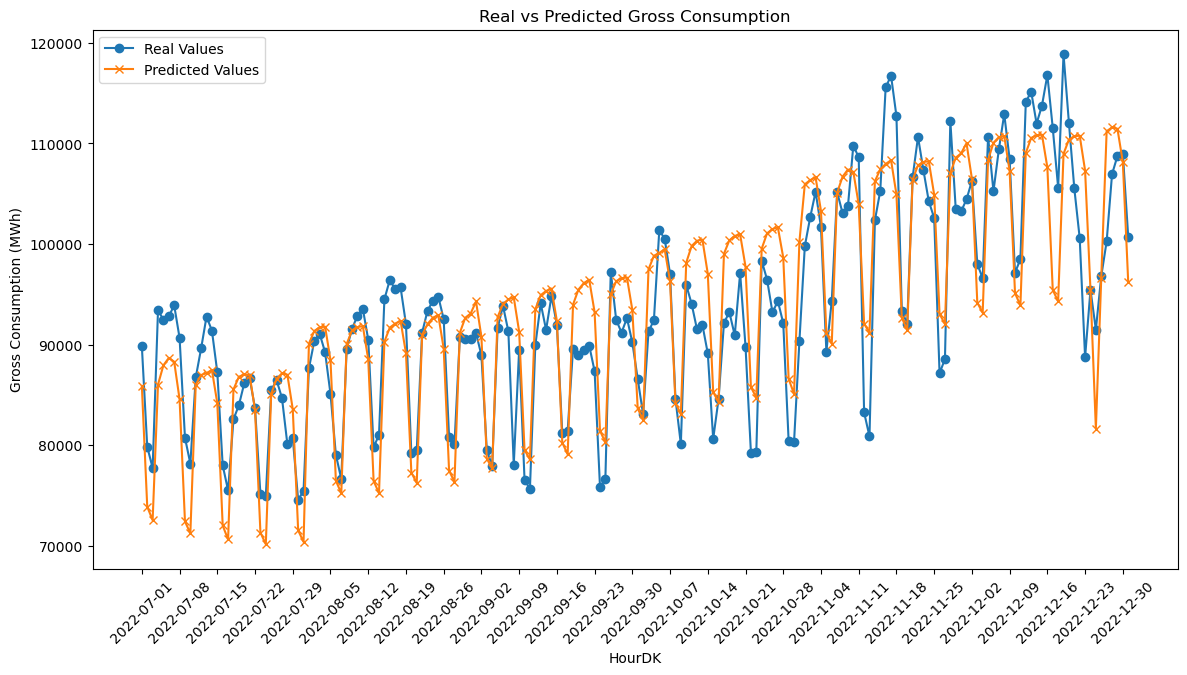

In [214]:
# Plotting the real and predicted values for better visualization
plt.figure(figsize=(14, 7))

# Plotting the real values
plt.plot(hour_dk_values, np.array(y_test), label='Real Values', marker='o')

# Plotting the predicted values
plt.plot(hour_dk_values, y_pred, label='Predicted Values', marker='x')

# Adding labels, title, and legend
plt.xlabel('HourDK')
plt.ylabel('Gross Consumption (MWh)')
plt.title('Real vs Predicted Gross Consumption')
plt.legend()

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Show only every 7th date
plt.xticks(hour_dk_values[::7])  # Replace 'hour_dk_values' with your actual array of dates

# Show the plot
plt.show()

In [215]:
# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#mse, rmse, mae, r2
print(f" MSE = {mse}\n MSE = {mse}\nRMSE = {rmse}\n  r2 = {r2}")

 MSE = 25927663.25065671
 MSE = 25927663.25065671
RMSE = 5091.921371217029
  r2 = 0.7661488941840506


\begin{align*}
\text{MSE}  &= 25,927,663.25 \\
\text{RMSE} &= 5091.92 \\
\text{MAE}  &= 4011.59 \\
R^2         &= 0.766
\end{align*}

1. MSE & RMSE: The MSE and RMSE values are measures of the average of the squares of the errors or deviations. In our case, the MSE is approximately $25.9$ million, and the RMSE is approximately $5092$. These values give us an idea of how much the predicted Gross Consumption deviates, on average, from the actual Gross Consumption in the dataset.

2. R-squared: The $R^2$ value is a statistical measure of the proportion of the variance for the dependent variable that's explained by the independent variables in the model. An $R^2$ value of $0.7661$ indicates that approximately 76.61% of the variability in Gross Consumption can be explained by our model. This suggests that the model has a relatively strong fit to the data.

In summary, the OLS regression model provides a decent fit to the interpolated dataset, explaining over 76% of the variance in Gross Consumption. However, there is room for improvement, as indicated by the MSE and RMSE values. Future work could involve feature engineering, using more complex models, or gathering more data to improve the model's performance.

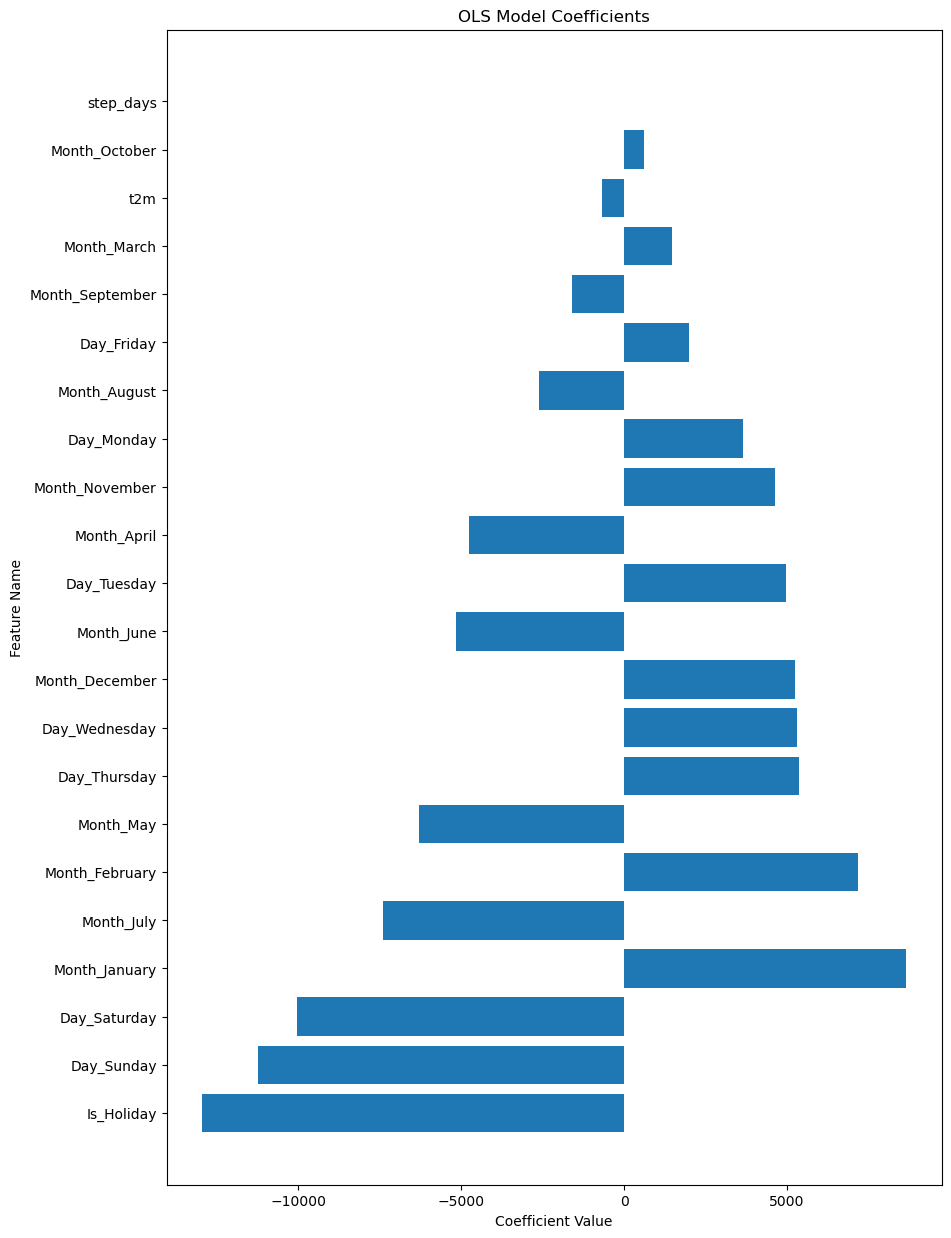

In [216]:
# Get the coefficients from the OLS model
coefficients = ols_model.coef_

# Get the feature names
feature_names = X_train.columns

# Create a DataFrame to hold coefficients and feature names
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of the coefficients
coeff_df['abs_coeff'] = np.abs(coeff_df['Coefficient'])
coeff_df = coeff_df.sort_values(by='abs_coeff', ascending=False)

# Drop the column used for sorting
coeff_df.drop('abs_coeff', axis=1, inplace=True)

# Plot the coefficients
plt.figure(figsize=(10, 15))
plt.barh(coeff_df['Feature'], coeff_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('OLS Model Coefficients')
plt.show()

The coefficients in a linear regression model help us understand the relationship between each independent variable and the dependent variable. In this case, the independent variables are various features like `Is_Holiday`, `Day of the Week`, `Month`, and so on. The dependent variable is `Gross Consumption`.

#### Interpretation:
1. `Is_Holiday`: A coefficient of −12,967 suggests that being a holiday decreases the gross consumption significantly. This could be due to reduced industrial activity or other factors.

2. `Day_Sunday` and `Day_Saturday`: These days have negative coefficients (−11,228 and −10,042, respectively), indicating lower consumption compared to the reference day.

3. `Month_January` and `Month_February`: These months have positive coefficients (8,666 and 7,175), indicating higher electricity consumption, possibly due to heating demands in winter.

4. `Day_Thursday` and `Day_Wednesday`: These weekdays have similar positive coefficients, suggesting a slight increase in consumption.

5. `Month_July` and `Month_May`: These months have negative coefficients, indicating a decrease in consumption, which could be due to vacations or more outdoor activities that reduce electricity use.

6. `t2m` (Temperature): The coefficient is −692, suggesting that for each unit increase in temperature, the gross consumption decreases by that amount, all else being equal.

7. `step_days`: A very low positive coefficient (8.94) suggests that the effect of this feature is minimal.

As we can see from the coefficients, the model identifies many of the same patterns that we observed in the [data](https://madsh0402.github.io/Forecasting-energy-consumption-in-Denmark/Data/Energy/Markdown/Energy%20Data/) 

#### Summary:
The coefficients provide valuable insights into factors that influence electricity consumption. For example, holidays and weekends generally lead to lower consumption, while certain months show increased consumption possibly due to seasonal factors.

Understanding these coefficients can help policymakers and energy companies make more informed decisions regarding electricity supply and demand.

# OLS for Flagged data

For the flagged data, we have to make some customizations. The "flagged" variable indicates where the consumption values are missing. Therefore, we need the model to predict 0 every time the flagged value is 1. By doing this, we are only predicting actual values and, hopefully, reducing the amount of noise compared to using interpolation. making the estimation equation:

$$
\begin{equation}
\hat y = 
\begin{cases} 
0 & \text{if flagged = 1} \\
\beta_0+\beta_1\cdot x_1 + \beta_2\cdot x_2 + \dots + \beta_n\cdot x_n & \text{otherwise} 
\end{cases}
\end{equation}
$$

In [217]:
# Re-split the data into training and test sets based on the criteria
training_set = data_flagged.loc[data_interpolation.index <= '2022-06-30']
test_set = data_flagged.loc[data_interpolation.index > '2022-06-30']


In [218]:
from sklearn.linear_model import LinearRegression
import numpy as np

# Define the feature variables (X) and the target variable (y) for training and test sets
# Make sure 'flagged' is included in X
X_train = training_set.drop(['GrossConsumptionMWh'], axis=1)
y_train = training_set['GrossConsumptionMWh']
X_test = test_set.drop(['GrossConsumptionMWh'], axis=1)
y_test = test_set['GrossConsumptionMWh']

# Initialize the OLS model
ols_model = LinearRegression()

# Fit the OLS model to the training data (excluding 'flagged')
ols_model.fit(X_train, y_train)

# Custom prediction function
def custom_predict(X, model):
    # Standard OLS prediction using all columns except 'flagged'
    y_ols = model.predict(X)
    
    # Apply the flagged logic
    y_pred = np.where(X['flagged'] == 1, 0, y_ols)
    
    return y_pred

# Make custom predictions on the test set
y_pred = custom_predict(X_test, ols_model)

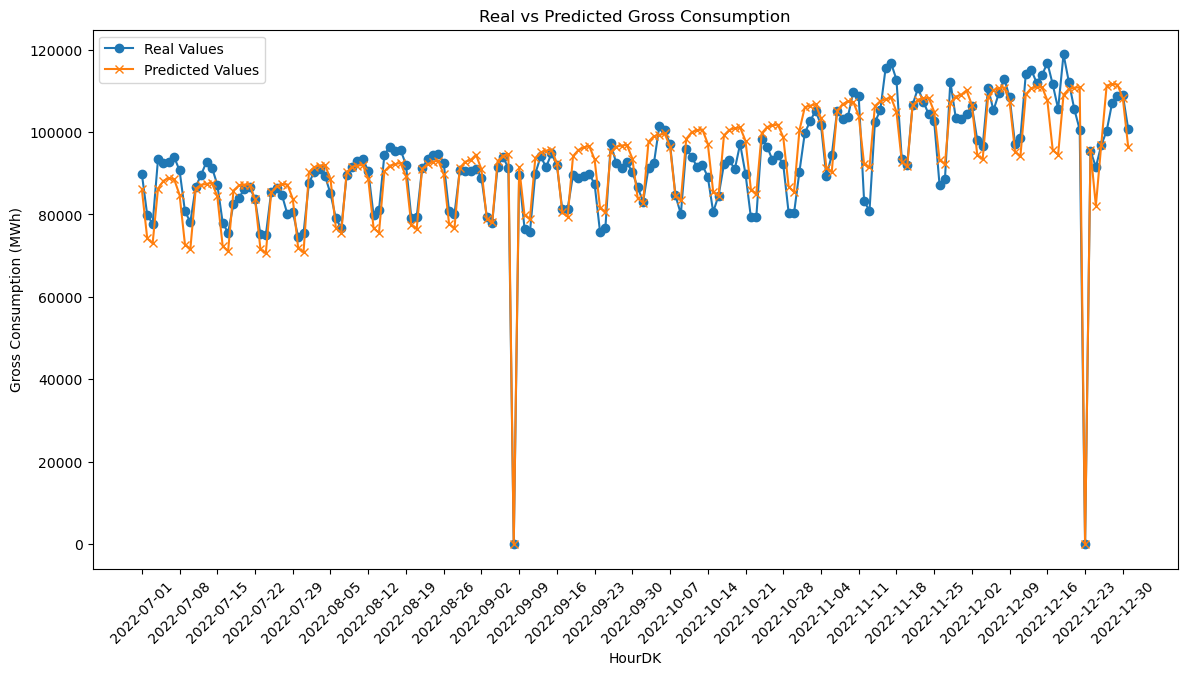

In [219]:
# Plotting the real and predicted values for better visualization
plt.figure(figsize=(14, 7))

# Plotting the real values
plt.plot(hour_dk_values, np.array(y_test), label='Real Values', marker='o')

# Plotting the predicted values
plt.plot(hour_dk_values, y_pred, label='Predicted Values', marker='x')

# Adding labels, title, and legend
plt.xlabel('HourDK')
plt.ylabel('Gross Consumption (MWh)')
plt.title('Real vs Predicted Gross Consumption')
plt.legend()

# Rotating x-axis labels for better readability
plt.xticks(rotation=45)

# Show only every 7th date
plt.xticks(hour_dk_values[::7])  # Replace 'hour_dk_values' with your actual array of dates

# Show the plot
plt.show()

In [220]:
# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

#mse, rmse, mae, r2
print(f" MSE = {mse}\nRMSE = {rmse}\n MAE = {mae}\n  r2 = {r2}")

 MSE = 22500416.754364517
RMSE = 4743.460419816372
 MAE = 3804.089889152245
  r2 = 0.8889467910286011


After applying the Ordinary Least Squares (OLS) regression model to the flagged dataset, we obtained the following performance metrics:

\begin{align*}
\text{MSE}  &= 22,500,16.75 \\
\text{RMSE} &= 4743.46 \\
\text{MAE}  &= 3804.09 \\
R^2         &= 0.889
\end{align*}

#### Interpretation and Comparison with Interpolated Dataset:
1. **MSE & RMSE**: The MSE and RMSE values for the flagged dataset are lower than those for the interpolated dataset (22,500,16.75 and 4743.46, respectively). This suggests that the model fits the flagged data slightly better.
2. **MAE**: The Mean Absolute Error for the flagged dataset is 3804.09, which is not directly comparable to the interpolated dataset as MAE was not provided for it. However, it gives us an idea of the average absolute error in the model.
3. R-squared: The $R^2$ value for the flagged dataset is 0.8894, which is higher than the 0.7661 for the interpolated dataset. This indicates that the model explains approximately 88.94% of the variance in Gross Consumption for the flagged dataset, as opposed to 76.61% for the interpolated dataset.

#### Summary:
Both models perform well, but the model trained on the flagged dataset shows better fit and predictive power. This could be because the flagged data might be cleaner or more consistent (the interpolation might add signifikant noise to the data) thereby leading to better model performance.

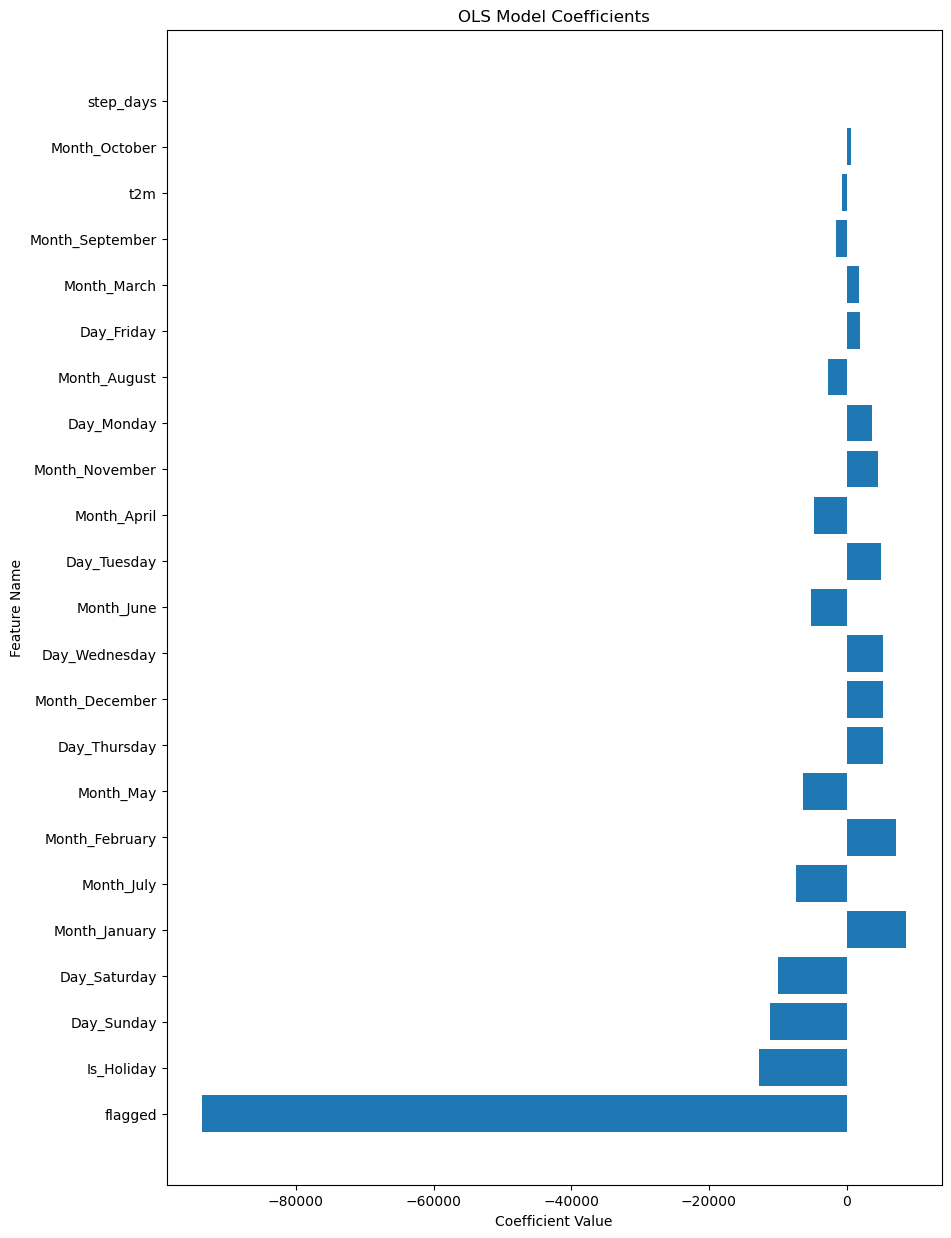

In [221]:
# Get the coefficients from the OLS model
coefficients = ols_model.coef_

# Get the feature names
feature_names = X_train.columns

# Create a DataFrame to hold coefficients and feature names
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the DataFrame by the absolute value of the coefficients
coeff_df['abs_coeff'] = np.abs(coeff_df['Coefficient'])
coeff_df = coeff_df.sort_values(by='abs_coeff', ascending=False)

# Drop the column used for sorting
coeff_df.drop('abs_coeff', axis=1, inplace=True)

# Plot the coefficients
plt.figure(figsize=(10, 15))
plt.barh(coeff_df['Feature'], coeff_df['Coefficient'])
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.title('OLS Model Coefficients')
plt.show()

When we look at the coefficients for the flagged dataset, some key differences and similarities emerge when compared to the interpolated data.

#### Interpretation:
1. `Flagged`: The most significant coefficient is for the 'flagged' variable, at -93,662. This suggests that the model is making a significant adjustment for missing data, predicting a sharp decline in gross consumption when the data is flagged as missing.

2. `Is_Holiday`: The coefficient for holidays is -12,752, which is very similar to what we observed in the interpolated dataset. This means that holidays are still found to be significant in reducing electricity consumption.

3. **Days of the Week**: The coefficients for `Day_Sunday` and `Day_Saturday` are also negative and of similar magnitude in both datasets. This consistency indicates that weekends usually see less electricity consumption compared to other days.

4. **Months**: The coefficients for `Month_January` and `Month_February` are positive, suggesting that the colder months lead to more electricity consumption. The months of July and May have negative coefficients, hinting at reduced electricity consumption, probably due to vacations or outdoor activities.

5. Temperature (t2m) and Step Days: The coefficients for temperature and step days are negative and positive, respectively, but their magnitudes are small, suggesting their impact is minimal. The values are very similar to those in the interpolated dataset.

#### Comparisons:
* The 'flagged' variable is a significant addition in this model. Its high negative value indicates the model's adjustment for the missing values.
* The coefficients for holidays, days of the week, and months are quite consistent between the flagged and interpolated datasets, indicating robustness in the model.
* The temperature and step days have minimal effects in both models, suggesting that these variables are not the primary drivers for changes in electricity consumption.
#### Summary:
The coefficients in the flagged dataset provide a nuanced understanding of electricity consumption patterns, accounting for missing data. Both the flagged and interpolated datasets offer similar insights into how holidays, weekdays, and months impact electricity consumption. The flagged dataset goes a step further by accounting for missing values, making it a more comprehensive model for understanding energy consumption patterns.